# 03 Quality Control

<b> Bart Theeuwes </b>

Quality of the different samples is inspected in order to set quality thresholds for the final analysis

In [1]:
#here::i_am("01_create_arrow.R")
source(here::here("settings.R"))
source(here::here("load_archr.R"))
options(repr.plot.width=15, repr.plot.height=5)

# I/O
io$output.directory <- file.path(io$basedir,"ArchR")
setwd(io$output.directory)
io$outdir <- file.path(io$output.directory,"QualityControl")
dir.create(file.path(io$outdir), showWarnings = FALSE)

Setting default number of Parallel threads to 1.

Setting addArchRVerbose = FALSE

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\__

#### Include stage in metadata

In [2]:
# Create metadata
archR_metadata <- getCellColData(ArchRProject) %>%
  as.data.table(keep.rownames = T) %>% setnames("rn","cell") %>%
  .[,c("cell", "TSSEnrichment", "ReadsInTSS", "PromoterRatio", "NucleosomeRatio", "nFrags", "DoubletEnrichment")] %>%
   .[,sample:=strsplit(cell,"#") %>% map_chr(1)]

stages = data.frame('sample' = c('rabbit_BGRGP1', 'rabbit_BGRGP2', 'rabbit_BGRGP3', 'rabbit_BGRGP4', 'rabbit_BGRGP5', 'rabbit_BGRGP6', 'rabbit_BGRGP7', 'rabbit_BGRGP8'),
                    'stage' = c('GD7', 'GD8', 'GD8', 'GD9_ExE', 'GD9', 'GD9', 'GD9', 'GD9' ))

archR_metadata = merge(archR_metadata, stages, by='sample')


metadata.to.archR <- archR_metadata %>% 
  .[cell%in%rownames(ArchRProject)] %>% setkey(cell) %>% .[rownames(ArchRProject)] %>%
  as.data.frame() %>% tibble::column_to_rownames("cell")

stopifnot(all(metadata.to.archR$TSSEnrichment_atac == getCellColData(ArchRProject, "TSSEnrichment")[[1]]))

for (i in colnames(metadata.to.archR)) {
  ArchRProject <- addCellColData(
    ArchRProject,
    data = metadata.to.archR[[i]], 
    name = i,
    cells = rownames(metadata.to.archR),
    force = TRUE
  )
}

fwrite(archR_metadata, file.path(io$output.directory, 'metadata.txt.gz'), sep="\t", na="NA", quote=F)

Warning message in .local(x, row.names, optional, ...):
“Arguments in '...' ignored”
Overriding previous entry for TSSEnrichment

Overriding previous entry for ReadsInTSS

Overriding previous entry for PromoterRatio

Overriding previous entry for NucleosomeRatio

Overriding previous entry for nFrags

Overriding previous entry for DoubletEnrichment



#### Inspect quality and define thresholds

In [8]:
######################
## Define arguments ##
######################
args = list()

args$min_nFrags = 8000
args$min_tss_score = 2.9
#args$max_doubletEnrichment = 10

library(patchwork)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



png 
  2

png 
  2

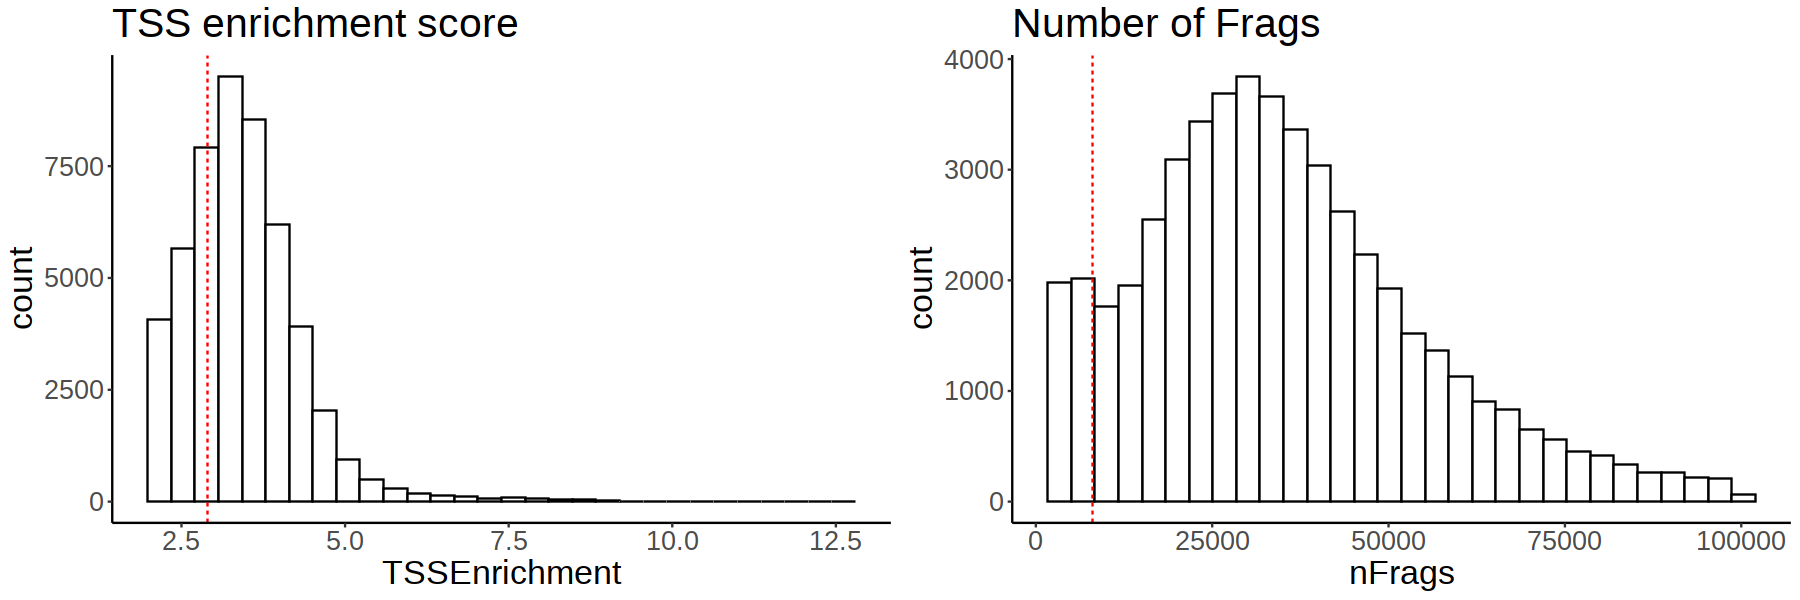

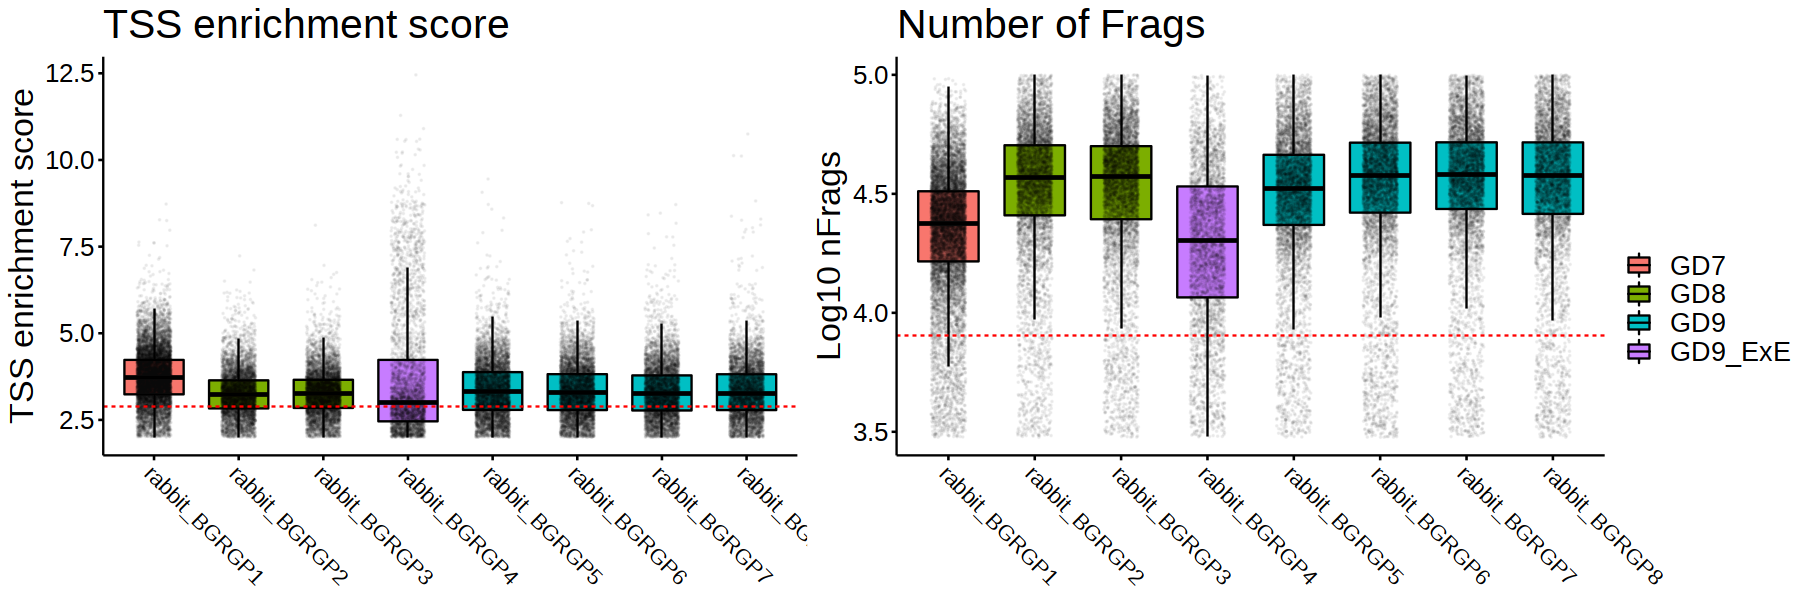

In [32]:
## Plot QC summary
# plot histograms
p1 = ggplot(archR_metadata, aes(TSSEnrichment)) + 
    geom_histogram(fill='white', color='black') + 
    ggtitle('TSS enrichment score') + 
    geom_vline(xintercept=args$min_tss_score, linetype='dashed', col='red') + 
    theme_classic() + theme(text=element_text(size=20))
p2 = ggplot(archR_metadata, aes(nFrags)) + 
    geom_histogram(fill='white', color='black') + 
    ggtitle('Number of Frags') + 
    geom_vline(xintercept=args$min_nFrags, linetype='dashed', col='red') + 
    theme_classic() + theme(text=element_text(size=20))
p3 = ggplot(archR_metadata, aes(DoubletEnrichment)) + 
    geom_histogram(fill='white', color='black') + 
    ggtitle('Doublet enrichment score') + 
#    geom_vline(xintercept=args$max_doubletEnrichment, linetype='dashed', col='red') + 
    theme_classic() + theme(text=element_text(size=20))
pA = ggarrange(p1, p2)
pdf(sprintf("%s/qc_metrics_histogram.pdf",io$outdir), width=15, height=8)
print(pA)
dev.off()
pA


# Plot boxplots
to.plot <- archR_metadata %>%
  .[,log_nFrags:=log10(nFrags)] %>%
  melt(id.vars=c("sample","cell","stage"), measure.vars=c("TSSEnrichment","log_nFrags", "DoubletEnrichment"))

# Boxplots
p4 <- ggboxplot(to.plot[variable=='TSSEnrichment'], x="sample", y="value", fill="stage", outlier.shape=NA) +
        geom_jitter(position=position_jitter(0.2), size = 0.001, alpha = 0.05) + 
       # facet_wrap(~variable, scales="free_y") +
        geom_hline(yintercept=args$min_tss_score, linetype='dashed', col='red') + 
        ggtitle('TSS enrichment score') + 
        ylab('TSS enrichment score') + 
        theme(
        legend.position = "right",
        legend.title = element_blank(),
        axis.text.x = element_text(colour="black",size=rel(0.65), angle=-45, hjust=0),  
        axis.text.y = element_text(colour="black",size=rel(0.75)),  
        axis.title.x = element_blank(),
        text=element_text(size=20)
        )
p5 <- ggboxplot(to.plot[variable=='log_nFrags'], x="sample", y="value", fill="stage", outlier.shape=NA) +
        geom_jitter(position=position_jitter(0.2), size = 0.001, alpha = 0.05) + 
       # facet_wrap(~variable, scales="free_y") +
        geom_hline(yintercept=log10(args$min_nFrags), linetype='dashed', col='red') + 
        ggtitle('Number of Frags') + 
        ylab('Log10 nFrags') + 
        theme(
        legend.position = "right",
        legend.title = element_blank(),
        axis.text.x = element_text(colour="black",size=rel(0.65), angle=-45, hjust=0),  
        axis.text.y = element_text(colour="black",size=rel(0.75)),  
        axis.title.x = element_blank(),
        text=element_text(size=20)
        ) 
pB = ggarrange(p4, p5, common.legend = TRUE, legend="right")
pdf(sprintf("%s/qc_metrics_boxplot.pdf",io$outdir), width=15, height=8)
print(pB)
dev.off()
pB

In [7]:
# % failing each QC criterium
paste0('pass TSSEnrichment: ',round(nrow(archR_metadata[archR_metadata$TSSEnrichment >= args$min_tss_score])/nrow(archR_metadata)*100,1), '%')
paste0('pass nFrags: ',round(nrow(archR_metadata[archR_metadata$nFrags>=args$min_nFrags])/nrow(archR_metadata)*100,1), '%')
paste0('pass all: ',round(nrow(archR_metadata[archR_metadata$nFrags>=args$min_nFrags & archR_metadata$TSSEnrichment >= args$min_tss_score])/nrow(archR_metadata)*100,1), '%')



paste0('Cell # before QC: ', nrow(archR_metadata))
#paste0('Cell # after QC: ', nrow(archR_metadata[archR_metadata$nFrags>=args$min_nFrags & archR_metadata$TSSEnrichment >= args$min_tss_score & archR_metadata$DoubletEnrichment<=args$max_doubletEnrichment,]))
paste0('Cell # after QC: ', nrow(archR_metadata[archR_metadata$nFrags>=args$min_nFrags & archR_metadata$TSSEnrichment >= args$min_tss_score,]))

[1] "pass TSSEnrichment: 72.7%"

[1] "pass nFrags: 92.4%"

[1] "pass all: 67.7%"

[1] "Cell # before QC: 50363"

[1] "Cell # after QC: 34082"

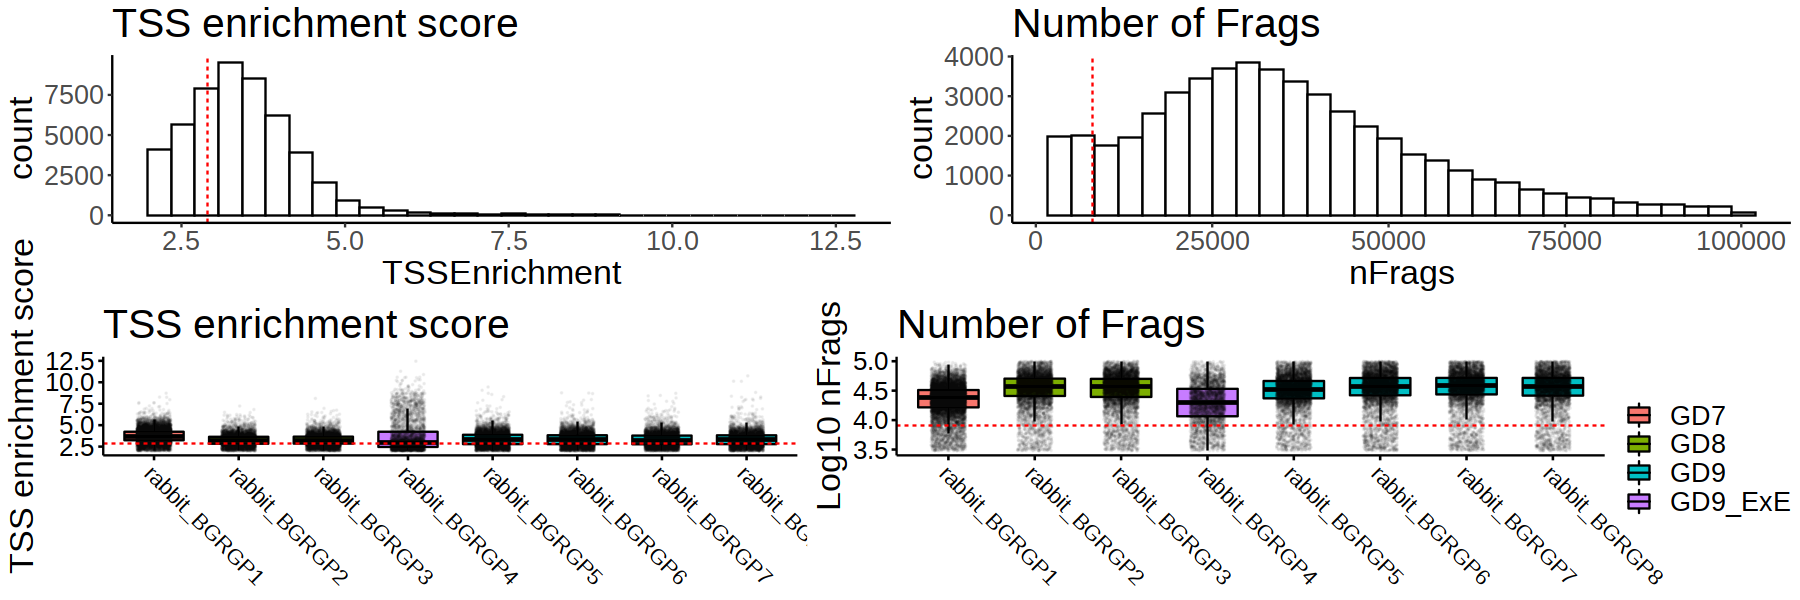

In [33]:
ggarrange(pA, pB, ncol = 1)

In [34]:
pdf(sprintf("%s/ATAC_supp_qc_metrics.pdf",io$sup_figures), width=15, height=8)
ggarrange(pA, pB, ncol = 1)
dev.off()

png 
  2

In [21]:
#############
## Call QC ##
#############
archR_metadata %>%
    .[,pass_atacQC:=TSSEnrichment>=args$min_tss_score & nFrags>=args$min_nFrags] %>%
    .[is.na(pass_atacQC),pass_atacQC:=FALSE]

fwrite(archR_metadata, file.path(io$output.directory, 'metadata_qc.txt.gz'), sep="\t", na="NA", quote=F)


######################### SAVE ###############################
#### FROM HERE ON WE ONLY WORK WITH CELLS THAT PASSED QC #####
##############################################################
archR_metadata_filt <- archR_metadata %>%
  .[pass_atacQC==TRUE] 
ArchRProject.filt <- ArchRProject[archR_metadata_filt$cell]

In [22]:
table(ArchRProject.filt@cellColData$sample)


rabbit_BGRGP1 rabbit_BGRGP2 rabbit_BGRGP3 rabbit_BGRGP4 rabbit_BGRGP5 
         8750          4082          4336          1629          4064 
rabbit_BGRGP6 rabbit_BGRGP7 rabbit_BGRGP8 
         3994          3771          3456 

In [23]:
saveArchRProject(ArchRProject.filt)

Saving ArchRProject...

Loading ArchRProject...

Successfully loaded ArchRProject!


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
         

class: ArchRProject 
outputDirectory: /rds/project/rds-SDzz0CATGms/users/bt392/04_rabbit_scATAC/ArchR/Project 
samples(8): rabbit_BGRGP1 rabbit_BGRGP2 ... rabbit_BGRGP7 rabbit_BGRGP8
sampleColData names(1): ArrowFiles
cellColData names(15): Sample TSSEnrichment ... sample stage
numberOfCells(1): 34082
medianTSS(1): 3.615
medianFrags(1): 33602